# Quantile-Quantile plots for eQTL, vQTL, and cQTLs

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm
import imp
pd.set_option('display.max_columns', 100)
import os
import pickle as pkl
%matplotlib inline

In [2]:
data_path  = '/data_volume/memento/lupus/'

In [36]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'silver', 'slategrey'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)


### QQ-plot function

In [32]:
def plotqq(pvalues):
    num_tests = pvalues.shape[0]
    unif_quantiles = stats.uniform.ppf(np.linspace(0, 1, num_tests))
    sorted_pvs = np.sort(pvalues)
    plt.scatter(-np.log10(unif_quantiles), -np.log10(sorted_pvs), s=1)
#     plt.plot(-np.log10(unif_quantiles), -np.log10(sorted_pvs))
    plt.plot([0, 6], [0, 6], '--', color='black')

### Get MAF filters

In [5]:
eur_pos = pd.read_csv(data_path + 'mateqtl_input/{}_genos.tsv'.format('eur'), sep='\t', index_col=0)
eur_min_freqs = eur_pos.apply(lambda x: pd.value_counts(x, normalize=True).iloc[-1], axis=1).reset_index(name='min_count')

In [6]:
asian_pos = pd.read_csv(data_path + 'mateqtl_input/{}_genos.tsv'.format('asian'), sep='\t', index_col=0)
asian_min_freqs = asian_pos.apply(lambda x: pd.value_counts(x, normalize=True).iloc[-1], axis=1).reset_index(name='min_count')

In [7]:
eur_min_freqs['pop'] = 'eur'
asian_min_freqs['pop'] = 'asian'

In [8]:
pos = pd.concat([eur_min_freqs, asian_min_freqs])

In [10]:
pos.head(5)

,CHROM:POS,min_count,pop
0,3:165182446,0.109890,eur
1,6:122682327,0.120879,eur
2,22:40561759,0.164835,eur
3,3:104381193,0.252747,eur
4,15:57107863,0.087912,eur


### QQ plots for vQTLs

In [11]:
vqtls = []
all_tests = []
for pop in ['asian', 'eur']:
    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:
        df = pd.read_csv(data_path + 'full_analysis/memento/100kb/{}_{}_variability.csv'.format(pop, ct))
        
        # Get gene means
        adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(pop, ct))
        means = adata.X.mean(axis=0).A1
        mean_df = pd.DataFrame()
        mean_df['gene'] = adata.var.index.tolist()
        mean_df['mean'] = means
        
        df['pop'] = pop
        df['ct'] = ct
        df = df.merge(mean_df, on='gene', how='left')
        
        if df.query('dv_fdr < 0.1').shape[0] > 0:
            vqtls.append(df.query('dv_fdr < 0.1'))
        all_tests.append(df)
vqtls = pd.concat(vqtls)
all_tests = pd.concat(all_tests)

In [12]:
filtered_tests = all_tests.merge(pos, left_on=['tx', 'pop'], right_on=['CHROM:POS', 'pop'], how='left').query('min_count > 0.1')

/tmp/ipykernel_12835/3247979387.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(unif_quantiles), -np.log10(sorted_pvs), s=1)


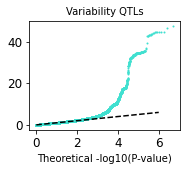

In [38]:
plt.figure(figsize=(2.7,2))
plt.title('Variability QTLs')
plotqq(filtered_tests.dv_pval.values)
plt.xlabel('Theoretical -log10(P-value)')
plt.savefig('QQ_vQTL.png', bbox_inches='tight', dpi=300)

### QQ plot for Coexpression QTLs

In [14]:
cqtls = []
all_ctests = []
for pop in ['asian', 'eur']:
    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:
        df = pd.read_csv(data_path + 'full_analysis/memento/100kb/{}_{}_coexpression.csv'.format(pop, ct))
        df['pop'] = pop
        df['ct'] = ct
        if df.query('corr_fdr < 0.1').shape[0] > 0:
            cqtls.append(df.query('corr_fdr < 0.1'))
            print(pop, ct, df.query('corr_fdr < 0.1')[['gene_1', 'gene_2']].drop_duplicates().shape[0])
        all_ctests.append(df)
cqtls = pd.concat(cqtls)
all_ctests = pd.concat(all_ctests)

asian T4 6
asian cM 48
asian ncM 121
asian T8 18
eur cM 31
eur ncM 8
eur T8 5
eur B 23


In [15]:
filtered_ctests = all_ctests.merge(pos, left_on=['tx', 'pop'], right_on=['CHROM:POS', 'pop'], how='left').query('min_count > 0.1')

/tmp/ipykernel_12835/1517188542.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(unif_quantiles), -np.log10(sorted_pvs), s=1)


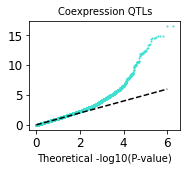

In [16]:
plt.figure(figsize=(2.7,2))
plt.title('Coexpression QTLs')
plotqq(filtered_ctests.corr_pval.values)
plt.xlabel('Theoretical -log10(P-value)')
plt.savefig('QQ_cQTL.png', bbox_inches='tight', dpi=300)

### QQ plot for eQTLs

In [17]:
memento = []
mateqtl = []
for pop in ['asian', 'eur']:
    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:

        mem = pd.read_table(data_path + 'full_analysis/memento/100kb/{}_{}.csv'.format(pop, ct), sep=',')
        meq = pd.read_table(data_path + 'full_analysis/mateqtl/outputs/{}_{}_all_hg19.csv'.format(pop, ct), sep='\t')
        
        mem['pop'] = pop
        meq['pop'] = pop
        mem['ct'] = ct
        meq['ct'] = ct
        
        memento.append(mem)
        mateqtl.append(meq)

In [18]:
memento = pd.concat(memento)
mateqtl = pd.concat(mateqtl)

In [20]:
filtered_memento = memento.merge(pos, left_on=['SNP', 'pop'], right_on=['CHROM:POS', 'pop'], how='left').query('min_count > 0.1')
filtered_mateqtl = mateqtl.merge(pos, left_on=['SNP', 'pop'], right_on=['CHROM:POS', 'pop'], how='left').query('min_count > 0.1')

/tmp/ipykernel_12835/3247979387.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(unif_quantiles), -np.log10(sorted_pvs), s=1)
/tmp/ipykernel_12835/635722510.py:7: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('QQ_eQTL.png', bbox_inches='tight', dpi=300)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


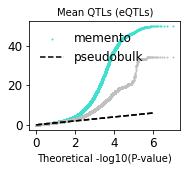

In [43]:
plt.figure(figsize=(2.7,2))
plt.title('Mean QTLs (eQTLs)')
plotqq(filtered_memento.query('log10p < 50')['p-value'].values)
plotqq(filtered_mateqtl['p-value'].values)
plt.xlabel('Theoretical -log10(P-value)')
# plt.legend(['memento', 'pseudobulk'], frameon=False);
plt.savefig('QQ_eQTL.png', bbox_inches='tight', dpi=300)